<a href="https://colab.research.google.com/github/aymericvie/Covid19_coevolution/blob/main/Covid_coevolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

initial pop virus
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
initial pop policies
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Evaluation of virusR--- 0.00426173210144043 seconds ---
mutqtion and replication of virus--- 5.435943603515625e-05 seconds ---
Current time: 0/27 with 7 new cases today
Evaluation of virusR--- 1.2159347534179688e-05 seconds ---
mutqtion and replication of virus--- 3.838539123535156e-05 seconds ---
Current time: 1/27 with 24 new cases today
Evaluation of virusR--- 2.2649765014648438e-05 seconds ---
mutqtion and replication of virus--- 7.367134094238281e-05 seconds ---
Current time: 2/27 with 77 new cases today
Evaluation of virusR--- 1.7404556274414062e-05 seconds ---
mutqtion and replication of virus--- 5.6743621826171875e-05 seconds ---
Current time: 3/27 with 248 new cases

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:229: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


mutqtion and replication of virus--- 0.1472609043121338 seconds ---
Current time: 23/27 with 478910539353 new cases today
Evaluation of virusR--- 0.0010194778442382812 seconds ---
mutqtion and replication of virus--- 0.49480366706848145 seconds ---
Current time: 24/27 with 1398418789138 new cases today
Evaluation of virusR--- 0.0009071826934814453 seconds ---
mutqtion and replication of virus--- 1.678760051727295 seconds ---
Current time: 25/27 with 4070797162419 new cases today
Evaluation of virusR--- 0.0013883113861083984 seconds ---
mutqtion and replication of virus--- 5.969032049179077 seconds ---
Current time: 26/27 with 11890798824413 new cases today
Evaluation of virusR--- 0.001322031021118164 seconds ---
mutqtion and replication of virus--- 20.455620288848877 seconds ---
Current time: 27/27 with 34352519258548 new cases today
[2.46, 2.41, 2.21, 2.2199999999999998, 2.1, 2.17, 2.11, 2.04, 2.02, 2.05, 2.0, 1.95, 1.7999999999999998, 1.72, 1.83, 1.72, 1.44, 1.48, 1.7200000000000002,

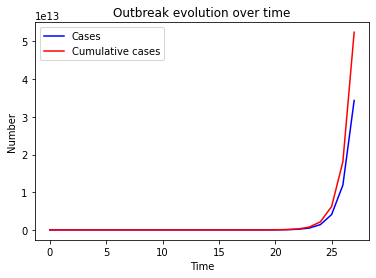

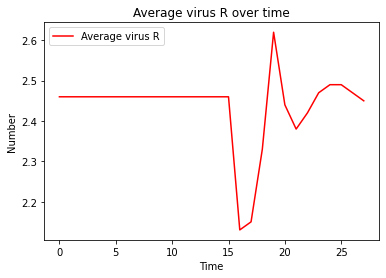

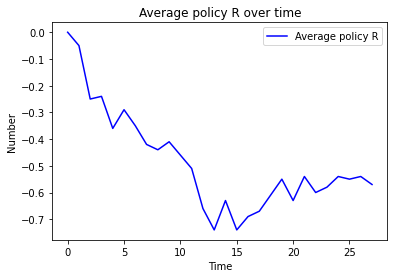

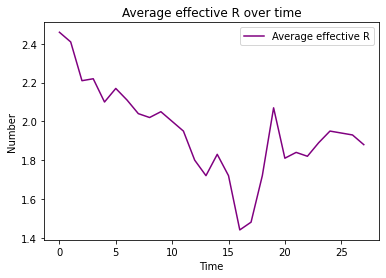

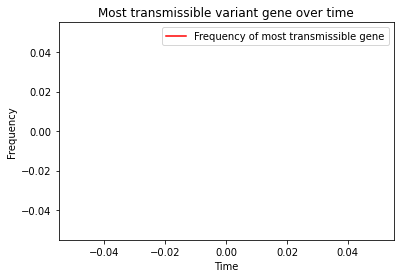

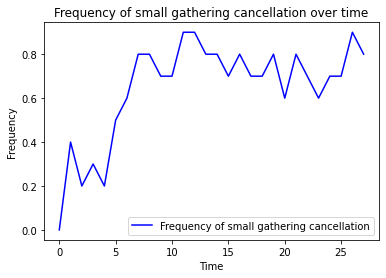

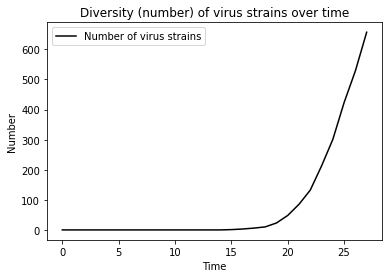

In [1]:
# imports
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from itertools import cycle 
np.set_printoptions(precision=3, suppress=True)
random.seed(9)

# Variable parameters
vaccine_mode = 0
population_policy_size = 10
tmax = 30
crossover_rate_policy = 0.9
mutation_rate_virus = 0.0001
mutation_rate_policy = 0.1

def coevolution(vaccine_mode, population_policy_size, tmax, crossover_rate_policy, mutation_rate_virus, mutation_rate_policy):
    # Fixed parameters
    virus_size = 10
    initial_virus_population = 2
    baseR = round(random.uniform(2,3),2)
    mut = np.arange(-1,1+1/10,(2/(virus_size-1)))

    if vaccine_mode == 1:
      policy_size = 1
    if vaccine_mode == 0:
      policy_size = 6 #should become 42

    # Parameters for non pharmaceutical interventions (NPIs) from Haug et al (2020)
    npi = [round(random.uniform(-0.36,-0.18),2), round(random.uniform(-0.24,-0.16),2), round(random.uniform(-0.24,-0.08),2), round(random.uniform(-0.18,-0.08),2), round(random.uniform(-0.18,-0.04),2), round(random.uniform(-0.18,0),2)]
    # should be adding the other ones


    # Initial sampling for viruses
    population_viruses = np.zeros((initial_virus_population,virus_size))
    print("initial pop virus")
    print(population_viruses)

    # Initial sampling for policies
    population_policies = np.zeros((population_policy_size,policy_size))
    population_virus_size = initial_virus_population

    print("initial pop policies")
    print(population_policies)


    t = 0
    # Initial results
    distribution_virus_genome = np.mean(population_viruses,0)
    distribution_policy_genome = np.mean(population_policies,0)
    virusR_history = []
    policyR_history = []
    cases = []
    cumulative_cases = []
    virus_diversity = []

    # Evolution loop
    while t < tmax+1:

      start_time = time.time()
      # determine efficacy of population viruses and policies
      if t == 0:
        unique, counts = np.unique(population_viruses, axis = 0, return_counts=True)
      #virusR = np.zeros((population_virus_size,1))
      #print("unique shape" + str(unique.shape[0]))
      virusR = np.zeros((unique.shape[0],1))
      i = 0
      while i < unique.shape[0]:
        #print(unique)
        #print(mut)
        virusR[i,0] = baseR + np.dot(unique[i,],mut) #np.sum(unique, axis = 1)[i]
        i += 1
      #print("virusR is" + str(virusR))
      print("Evaluation of virusR" + "--- %s seconds ---" % (time.time() - start_time))

      #start_time = time.time()
      policyR = np.zeros((population_policy_size,1))
      i = 0
      while i < population_policy_size:
        policyR[i,0] = np.dot(population_policies[i,],npi)
        i += 1
      #print("Evaluation of policyR" + "--- %s seconds ---" % (time.time() - start_time))

      # evaluate coevolution fitness evaluation for policies, with tournament(3) selection
      policy_fitness = np.zeros((population_policy_size,1))

      #start_time = time.time()
      i = 0
      while i < population_policy_size:
        cumulative_number_variant = np.copy(counts)
        #print(cumulative_number_variant)

        #print(counts)
        #print(unique.shape[0])
        #print(len(cumulative_number_variant))

        if unique.shape[0] > 1:
          j = 0
          while j < len(cumulative_number_variant):
            cumulative_number_variant[j] += cumulative_number_variant[j-1]
            j += 1
        #print(unique.shape[0])
        a = random.randint(0,unique.shape[0]-1)
        aa = 0
        while a > cumulative_number_variant[aa]:
          aa += 1

        b = random.randint(0,unique.shape[0]-1)
        bb = 0
        while b > cumulative_number_variant[bb]:
          bb += 1

        c = random.randint(0,unique.shape[0]-1)
        cc = 0
        while c > cumulative_number_variant[cc]:
          cc += 1

        policy_fitness[i,0] = (1/3)*(virusR[aa,0] + virusR[bb,0] + virusR[cc,0]) + policyR[i,0]
        i += 1
      adjusted_policy_fitness = 1/(1+policy_fitness)
      policy_selection = adjusted_policy_fitness / np.sum(adjusted_policy_fitness)
      #print("Evaluation of policyR fitness vs virusR" + "--- %s seconds ---" % (time.time() - start_time))

      #start_time = time.time()
      cumulative_policy_selection = np.copy(policy_selection)
      i = 1
      while i < len(cumulative_policy_selection):
        cumulative_policy_selection[i,0] += cumulative_policy_selection[i-1,0]
        i += 1

      i = 0
      while i < population_policy_size:
        a = random.uniform(0,1)
        b = 0
        while a > cumulative_policy_selection[b]:
            b += 1

        a = random.uniform(0,1)
        c = 0
        while a > cumulative_policy_selection[c]:
            c += 1

      # Do crossover between elements b and c

        offspring1 = np.zeros((1, policy_size))
        offspring2 = np.zeros((1, policy_size))

        n = random.uniform(0,1)
        if n <= crossover_rate_policy:

          cpoint = random.randint(0,policy_size)
          j = 0
          while j < cpoint:
            offspring1[0,j] = population_policies[b,j]
            offspring2[0,j] = population_policies[c,j]
            j += 1
          while j < policy_size:
            offspring1[0,j] = population_policies[c,j]
            offspring2[0,j] = population_policies[b,j]
            j += 1

        elif n > crossover_rate_policy:
          offspring1 = np.copy(population_policies[b,])
          offspring2 = np.copy(population_policies[c,])
          offspring2 = offspring2.reshape((1,policy_size))
          offspring1 = offspring1.reshape((1,policy_size))
        k = 0
        while k < policy_size:
          n = random.uniform(0,1)
          if n <= mutation_rate_policy:
            if offspring1[0,k] == 0:
              offspring1[0,k] = 1
            elif offspring1[0,k] == 1:
              offspring1[0,k] = 0
          k += 1

        k = 0
        while k < policy_size:
          n = random.uniform(0,1)
          if n <= mutation_rate_policy:
            if offspring2[0,k] == 0:
              offspring2[0,k] = 1
            elif offspring2[0,k] == 1:
              offspring2[0,k] = 0
          k += 1

        population_policies = np.vstack([population_policies,offspring1])
        population_policies = np.vstack([population_policies,offspring2])
        i += 2
      #print("Crossover qnd mutqtion of policyR" + "--- %s seconds ---" % (time.time() - start_time))

      #print("new pop polici")
      population_policies = population_policies[population_policy_size:, :]
      #print(population_policies)
      start_time = time.time()

      next_unique = np.copy(unique)
      next_counts = np.copy(counts)

      # operate virus transmission and mutation
      i = 0
      #population_virus_mut = np.zeros((1,virus_size))
      while i < unique.shape[0]:
        j = 0
        m = int(round((virusR[i,0]+np.mean(policyR))*counts[i]))

        # and now m * (1 - mutation_rate) are just similar, we record their weights and will update counts later. They don't change unique!
        next_counts[i] += round(m * (1 - mutation_rate_virus))
       # print("new count added")
        #print(next_counts)

        # Proportion m  * mutation_rate_virus will mutate
        while j < round(m*mutation_rate_virus):
          candidate_virus = np.copy(unique[i,])
          k = 0
          while k < virus_size:
            n = random.uniform(0,1)
            if n <= 1/virus_size:
              if candidate_virus[k] == 0:
                candidate_virus[k] = 1
              elif candidate_virus[k] == 1:
                candidate_virus[k] = 0
            k += 1
          
          if any((next_unique[:]==candidate_virus).all(1)):
            z = np.asscalar(np.where((next_unique == candidate_virus).all(axis=1))[0])
            next_counts[z] += 1

          if not any((next_unique[:]==candidate_virus).all(1)):
            next_unique = np.vstack([next_unique, candidate_virus]) 
            next_counts = np.hstack([next_counts, 1])
            #print("new variant detected"+str(candidate_virus))
            #print(next_unique)
            #print(next_counts)
          j += 1
        


        i += 1
      print("mutqtion and replication of virus" + "--- %s seconds ---" % (time.time() - start_time))

      #print("shape of counts " + str(next_counts.shape[0]) + " shape of unique" + str(next_unique.shape[0]))
      #print(next_counts)
      #print(next_unique)

      unique = np.copy(next_unique)
      counts = np.copy(next_counts)

      population_viruses = population_viruses[population_virus_size:, :]
      population_virus_size = population_viruses.shape[0]
      #print("Virus pop size "+str(population_virus_size))

      # Save results
      if t > 0:
        distribution_virus_genome = np.vstack([distribution_virus_genome,np.mean(population_viruses,0)]) ########################################## BUGGED
        distribution_policy_genome = np.vstack([distribution_policy_genome,np.mean(population_policies,0)]) 

      virusR_history.append(round(np.mean(virusR),2))
      policyR_history.append(round(np.mean(policyR),2))
      cases.append(np.sum(counts))
      cumulative_cases.append(np.sum(cases))

      #print(unique)
      #print(counts)

      #unique, counts = np.unique(population_viruses, axis = 0, return_counts=True)
      virus_diversity.append(unique.shape[0])

      #counts = [x + y for x, y in zip(cycle(counts), counts2)] 


      print("Current time: " + str(t)+"/"+str(tmax) + " with " + str(np.sum(counts)) + " new cases today")
      t += 1
    del t


    # Graphical results
    timer = list(range(0,tmax+1))
    effectiveR = [sum(x) for x in zip(virusR_history, policyR_history)]           # when adding the vaccine, neeed a way to count vaccine effect in effective R rate
    print(effectiveR)

    # cases and cumulative cases
    plt.plot(timer, cases, label = "Cases", color = "blue")
    plt.plot(timer, cumulative_cases, label = "Cumulative cases", color = "red")
    plt.xlabel('Time')
    plt.ylabel('Number')
    plt.title('Outbreak evolution over time')
    plt.legend()
    plt.show()

    # evolution of average virus R
    plt.plot(timer, virusR_history,color = "red", label ="Average virus R")
    plt.xlabel('Time')
    plt.ylabel('Number')
    plt.title('Average virus R over time')
    plt.legend()
    plt.show()

    # evolution of policy virus R
    plt.plot(timer, policyR_history,color = "blue", label ="Average policy R")
    plt.xlabel('Time')
    plt.ylabel('Number')
    plt.title('Average policy R over time')
    plt.legend()
    plt.show()

    # evolution of policy virus R
    plt.plot(timer, effectiveR,color = "purple", label ="Average effective R")
    plt.xlabel('Time')
    plt.ylabel('Number')
    plt.title('Average effective R over time')
    plt.legend()
    plt.show()

    # evolution of highest R mutation variant
    plt.plot(timer, distribution_virus_genome[:,virus_size-1],color = "red", label ="Frequency of most transmissible gene")
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Most transmissible variant gene over time')
    plt.legend()
    plt.show()

    # evolution of best policy measure (small gathering cancellation)
    plt.plot(timer, distribution_policy_genome[:,0],color = "blue", label ="Frequency of small gathering cancellation")
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Frequency of small gathering cancellation over time')
    plt.legend()
    plt.show()

    # Evolution of virus variants number
    plt.plot(timer, virus_diversity,color = "black", label ="Number of virus strains")
    plt.xlabel('Time')
    plt.ylabel('Number')
    plt.title('Diversity (number) of virus strains over time')
    plt.legend()
    plt.show()



vaccine_mode = 0
population_policy_size = 10
tmax = 27
crossover_rate_policy = 0.9
mutation_rate_virus = 0.00000001
mutation_rate_policy = 0.1

coevolution(vaccine_mode, population_policy_size, tmax, crossover_rate_policy, mutation_rate_virus, mutation_rate_policy)





In [ ]:
print(distribution_virus_genome)
print(distribution_policy_genome)
print(virusR_history)
print(policyR_history)

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.   ]
 [0.    0.001 0.    0.    0.    0.    0.    0.002 0.    0.   ]
 [0.    0.002 0.    0.    0.    0.    0.001 0.003 0.    0.   ]
 [0.    0.003 0.    0.    0.001 0.001 0.001 0.005 0.    0.   ]
 [0.001 0.006 0.    0.    0.001 0.001 0.002 0.01  0.    0.001]
 [0.001 0.011 0.    0.    0.002 0.002 0.005 0.019 0.    0.001]
 [0.003 0.02  0.001 0.001 0.004 0.004 0.009 0.036 0.    0.002]
 [0.005 0.037 0.002 0.002 0.007 0.008 0.016 0.067 0.001 0.004]
 [0.009 0.064 0.003 0.004 0.013 0.014 0.028 0.114 0.001 0.006]
 [0.014 0.099 0.004 0.006 0.02  0.021 0.044 0.178 0.002 0.01 ]
 [0.02  0.141 0.006 0.009 0.029 0.03  0.062 0.253 0.003

In [ ]:
print(mut)

[-1.  -0.8 -0.6 -0.4 -0.2 -0.   0.2  0.4  0.6  0.8  1. ]


In [ ]:
print(npi)

[-0.29, -0.23, -0.1, -0.18, -0.11, -0.02]
